Specifying which stats we want to readback from bluesky plans

In [18]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

In [50]:
# create the SimDetector Device with a TIFF filesave mixin

# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam, ColorConvPlugin)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCam, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')
    colour = Cpt(ColorConvPlugin, 'CC1:')
    
    
#assumes that the plugins are blocking
def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.stats.sigma_x.kind = 'hinted'
    det.stats.blocking_callbacks.set('Yes')
    det.stats.sigma_y.kind = 'hinted'
    det.colour.kind = 'normal'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.tiff.nd_array_port.put(det.colour.port_name.get()) # makes the tiff plugin take the output of the colour change plugin



In [51]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')

In [52]:
my_sim_cam.wait_for_connection()

In [53]:
set_detector(my_sim_cam)


In [54]:
import databroker.core
handler_registry = databroker.core.discover_handlers()
# make sure that the python package area-detector-handlers is installed!

In [55]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 4     Time: 2021-08-25 12:38:13
Persistent Unique Scan ID: '79dd421f-a0a3-4c03-aefe-147b1d680621'
New stream: 'primary'
+-----------+------------+--------------------+--------------------+------------------+
|   seq_num |       time | test_stats_sigma_x | test_stats_sigma_y | test_stats_total |
+-----------+------------+--------------------+--------------------+------------------+
|         1 | 12:38:13.6 |               96.2 |               97.7 |         12290170 |
+-----------+------------+--------------------+--------------------+------------------+
generator count ['79dd421f'] (scan num: 4)





('79dd421f-a0a3-4c03-aefe-147b1d680621',)

In [56]:
from bessyii_devices.positioners import PVPositionerComparator
from ophyd import Component as Cpt
from ophyd import EpicsSignal, EpicsSignalRO


        
class MySimCamSigmaX(PVPositionerComparator):
    
    setpoint = Cpt(EpicsSignal, 'cam1:PeakWidthX')
    readback = Cpt(EpicsSignalRO, 'cam1:PeakWidthX_RBV')
    
    atol = 0.1
    
    def done_comparator(self, readback, setpoint):
        return setpoint-self.atol < readback < setpoint+self.atol

    
#could use Fcpt but can't be bothered
class MySimCamSigmaY(PVPositionerComparator):
    
    setpoint = Cpt(EpicsSignal, 'cam1:PeakWidthY')
    readback = Cpt(EpicsSignalRO, 'cam1:PeakWidthY_RBV')
    
    atol = 0.1
    
    def done_comparator(self, readback, setpoint):
        return setpoint-self.atol < readback < setpoint+self.atol



my_sim_cam_sigma_x = MySimCamSigmaX('SISSY1EX:Simdetector1:', name='my_sim_cam_sigma_x')

my_sim_cam_sigma_y = MySimCamSigmaY('SISSY1EX:Simdetector1:', name='my_sim_cam_sigma_y')

my_sim_cam_sigma_x.wait_for_connection()
my_sim_cam_sigma_y.wait_for_connection()



Transient Scan ID: 5     Time: 2021-08-25 12:38:15
Persistent Unique Scan ID: '039ded1b-9189-4d53-8ce5-bed3f933d513'
New stream: 'primary'
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|   seq_num |       time | my_sim_cam_sigma_x_readback | my_sim_cam_sigma_y_readback | test_stats_sigma_x | test_stats_sigma_y | test_stats_total |
+-----------+------------+-----------------------------+-----------------------------+--------------------+--------------------+------------------+
|         1 | 12:38:15.3 |                          10 |                          10 |                9.8 |                9.8 |           123376 |
|         2 | 12:38:15.7 |                          20 |                          20 |               19.5 |               19.5 |           493600 |
|         3 | 12:38:16.0 |                          30 |                          30 |               29.3 |            

('039ded1b-9189-4d53-8ce5-bed3f933d513',)

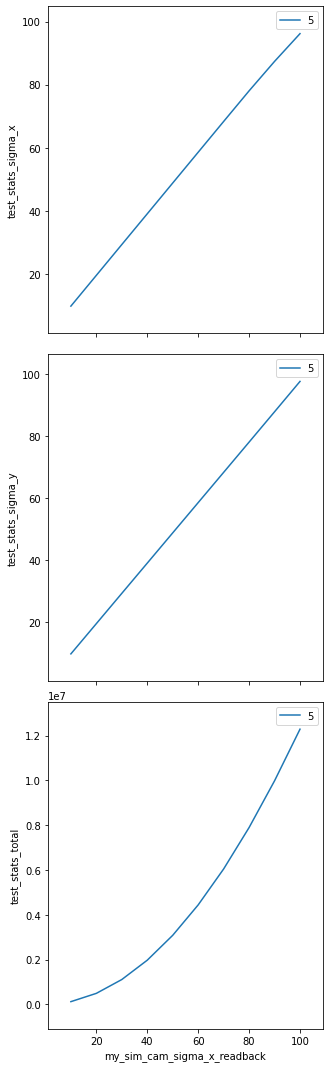

In [57]:
from bessyii.plans.scan import scan

RE(scan([my_sim_cam],my_sim_cam_sigma_x,10,100,my_sim_cam_sigma_y,10,100,10))